# Timesfm Usage Example

## Loading Timesfm Model

In [ ]:
import os
import sys
import numpy as np

src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from samay.model import TimesfmModel
from samay.dataset import TimesfmDataset

repo = "google/timesfm-1.0-200m-pytorch"
config = {
    "context_len": 512,
    "horizon_len": 192,
    "backend": "gpu",
    "per_core_batch_size": 32,
    "input_patch_len": 32,
    "output_patch_len": 128,
    "num_layers": 20,
    "model_dims": 1280,
    "quantiles": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

tfm = TimesfmModel(config=config, repo=repo)


Using device: cuda:2


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

## Define the datasets

In [ ]:
train_dataset = TimesfmDataset(
    name="ett",
    datetime_col="date",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    mode="train",
    context_len=config["context_len"],
    horizon_len=128,
)
val_dataset = TimesfmDataset(
    name="ett",
    datetime_col="date",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    mode="test",
    context_len=config["context_len"],
    horizon_len=config["horizon_len"],
)

## Evaluate the zero-shot forecasting

In [3]:
avg_loss, trues, preds, histories = tfm.evaluate(val_dataset)
print("Validation loss:", avg_loss)

Validation loss: 0.5428836594025294


## Visualization of the evaluation

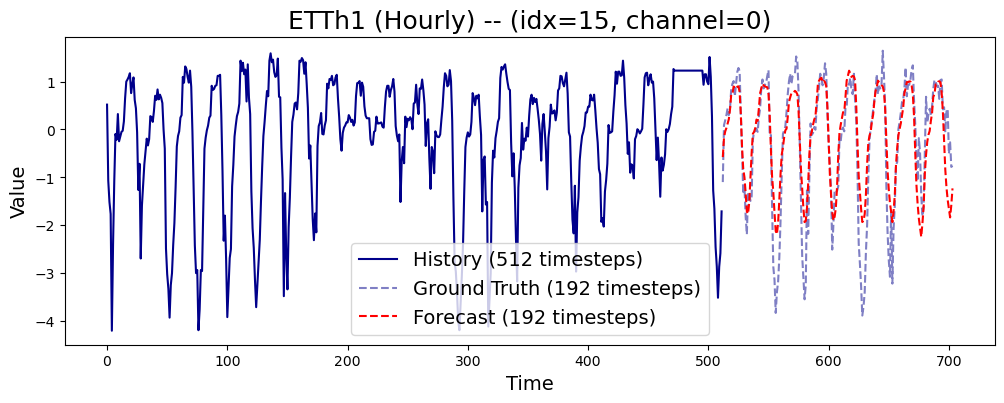

In [ ]:
import matplotlib.pyplot as plt

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Finetune Timesfm Model on the ETT dataset

In [5]:
finetuned_model = tfm.finetune(train_dataset)

Epoch 0, Loss: 3.359409625056512
Epoch 1, Loss: 3.191326842722758
Epoch 2, Loss: 3.021095032778058
Epoch 3, Loss: 2.8970536288610735
Epoch 4, Loss: 2.788282239718137
Epoch 5, Loss: 2.69049363157694
Epoch 6, Loss: 2.6051189395429635
Epoch 7, Loss: 2.5270865494686934
Epoch 8, Loss: 2.4563758475084576
Epoch 9, Loss: 2.3911879633625124


## Test the Finetuned Model

In [6]:
avg_loss, trues, preds, histories = tfm.evaluate(val_dataset)
print("Validation loss:", avg_loss)

Validation loss: 0.509589419596725


## Visualization of the evaluation

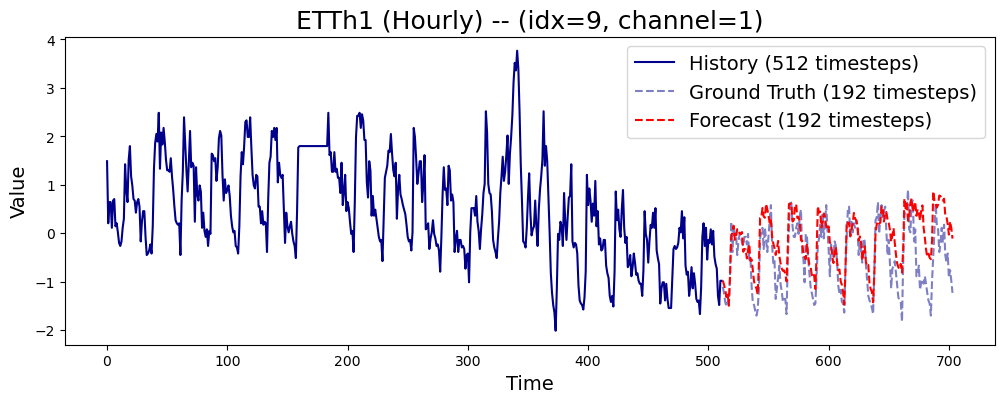

In [ ]:
import matplotlib.pyplot as plt

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()